
# SierraVolt Energética Limitada
Estimación de daño en patrimonio producido por incendios.


<br>



#### ***Participante:*** 
#### Francisco Rizzi (Synthetica)

[ <img src="https://i.imgur.com/danOJQk.jpeg" width=200 height=200 styles="object-fit: cover;"> <br> <sub>Data Science Student</sub> ](https://www.linkedin.com/in/franciscorizzi/)


### Comenzamos con instalar las librerias necesarias para nuestro estudio:

In [1]:
import pandas as pd
import numpy as np

import geopandas as gpd
import json

from pykml import parser

import rasterio
import rasterio.mask

from rasterio import plot
import matplotlib.pyplot as plt

from shapely import Polygon
from pyproj import Transformer

import seaborn as sns
import seaborn.objects as so
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler

import tensorflow as tf
import keras
from keras import regularizers


### Por cuestiones de comodidad, preferi extraer los datos de las parcelas en formato JSON.

```
Los datos que nos interesan son elementos de una lista. Cada elemento se llama 
> feature 
Defenimos entonces una funcion que nos extrae la informacion relevante de cada feature en su formato correcto
```

<br>

In [2]:
def featureToDict( elem ):

    data = {
            'id': elem["id"],
            'geometry': elem["geometry"],
            'par_idparcela': elem["properties"]['par_idparcela'],
            'Nomenclatura': elem["properties"]['Nomenclatura'],
            'Tipo_Parcela': elem["properties"]['Tipo_Parcela'],
            'Tipo_Valuacion': elem["properties"]['Tipo_Valuacion'],
            'Estado': elem["properties"]['Estado'],
            'desig_oficial': elem["properties"]['desig_oficial'],
            'exp_creacion': elem["properties"]['exp_creacion'],
            'Fecha_Creacion': elem["properties"]['Fecha_Creacion'],
            'fecha_alta_parcela': elem["properties"]['fecha_alta_parcela'],
            'vut_vigente': elem["properties"]['vut_vigente'],
            'Valuacion': elem["properties"]['Valuacion'],
            'vigencia_desde': elem["properties"]['vigencia_desde'],
            'porcentaje_copropiedad': elem["properties"]['porcentaje_copropiedad'],
            'Superficie_Tierra_Urbana': elem["properties"]['Superficie_Tierra_Urbana'],
            'Valuacion_Tierra_Urbana': elem["properties"]['Valuacion_Tierra_Urbana'],
            'base_imponible_tierra_urbana': elem["properties"]['base_imponible_tierra_urbana'],
            'Superficie_Tierra_Rural': elem["properties"]['Superficie_Tierra_Rural'],
            'Valuacion_Tierra_Rural': elem["properties"]['Valuacion_Tierra_Rural'],
            'base_imponible_tierra_rural': elem["properties"]['base_imponible_tierra_rural'],
            'Superficie_Mejoras': elem["properties"]['Superficie_Mejoras'],
            'Valuacion_Mejoras':  elem["properties"]['Valuacion_Mejoras'],
            'base_imponible_mejoras': elem["properties"]['base_imponible_mejoras'],
            'Cantidad_Cuentas':  elem["properties"]['Cantidad_Cuentas'],
            'departamento':  elem["properties"]['departamento'],
            'pedania': elem["properties"]['pedania'],
            'localidad':  elem["properties"]['localidad'],
            'par_entityid': elem["properties"]['par_entityid'],
            'row_number': elem["properties"]['row_number'],
            'Nro_Cuenta':  elem["properties"]['Nro_Cuenta'],
            'ped_nomenclatura': elem["properties"]['ped_nomenclatura'],
            'bbox' : elem.get("bbox")
    }

    return data

## Creamos el CSV que contiene la informacion de las parcelas de SAN ROQUE y Santiago
```
Usamos la funcion anterior para cada elemento extraido del JSON de San Roque y Santiago
```
<br>

In [3]:
data = json.load( open("parcelasSanRoque.json") )

dataDF = []

for elem in data["features"]:
    aux = featureToDict(elem)
    dataDF.append(aux)
    
SanRoque = pd.DataFrame(dataDF)

# Suelto las parcelas que no tienen un poligono definido (es literalmente una sola...)
filtro = SanRoque["geometry"].apply( lambda x : type(x) == type({}) )
SanRoque = SanRoque[filtro].reset_index( drop= True)

# Transformo la geometria en coordenadas del poligno
SanRoque["geometry"] = SanRoque["geometry"].apply( lambda elem : [tuple(x) for x in elem["coordinates"][0][0]] )


In [4]:
data = json.load( open("parcelasSantiago.json") )

dataDF = []

for elem in data["features"]:
    aux = featureToDict(elem)
    dataDF.append(aux)
    
Santiago = pd.DataFrame(dataDF)

# Transformo la geometria en coordenadas del poligno
Santiago["geometry"] = Santiago["geometry"].apply( lambda elem : [tuple(x) for x in elem["coordinates"][0][0]] )

<br>

```
Todavia no tratamos los datos correctamente, pero son datos "sin refinar" que nos serviran mas adelante
```
<br>

### Crear las imagenes NDVI y DNBR de Cordoba.
```
Comienzo con las imagenes post incendio del 22 de noviembre de 2023 del NDVI de la region de Cordoba.

```

In [5]:
# Creacion de imagen NDVI post incendio:


# Leemos las bandas 4 y 5 del Landasat 8.

band4 = rasterio.open("LC08_L2SP_229082_20231122_20231128_02_T1_SR_B4.TIF") #red
band5 = rasterio.open("LC08_L2SP_229082_20231122_20231128_02_T1_SR_B5.TIF") #nir

# Las formateamos como arrays de floats
red = band4.read(1).astype('float64')
nir = band5.read(1).astype('float64')

# Y tomamos el ndvi (si la suma da cero entonces el ndvi es cero para evitar indeterminaciones)
ndvi = np.where(
                (nir+red)==0.,
                0,
                (nir-red)/(nir+red)
        )


# Exportamos la imagen rasterizda para usarlo luego
ndviImage = rasterio.open('./exports/ndviPostImage.tiff', 'w', driver='Gtiff',
                          width=band4.width, height=band4.height,
                          count=1,
                          crs=band4.crs,
                          transform=band4.transform,
                          dtype='float64'                  
                         )

ndviImage.write(ndvi,1)

ndviImage.close()


C:\Users\Xenon\AppData\Local\Temp\ipykernel_6484\958961467.py:17: RuntimeWarning: invalid value encountered in divide
  (nir-red)/(nir+red)


In [6]:
# Creacion de imagen DNBR post incendio:


# Leemos las bandas 5 y 7 del Landsat 8.

band5 = rasterio.open("LC08_L2SP_229082_20231122_20231128_02_T1_SR_B5.TIF") #nir
band7 = rasterio.open("LC08_L2SP_229082_20231122_20231128_02_T1_SR_B7.TIF") #swir

# Las formateamos como arrays de floats
nir = band5.read(1).astype('float64')
swir = band7.read(1).astype('float64')


# Y tomamos el dnbr (si la suma da cero entonces el dnbr es cero para evitar indeterminaciones)
dnbr = np.where(
                (nir+swir)==0.,
                0,
                (nir-swir)/(nir+swir)
        )


# Exportamos la imagen rasterizada para usarla luego
dnbrImage = rasterio.open('./exports/dnbrPostImage.tiff', 'w', driver='Gtiff',
                          width=band7.width, height=band7.height,
                          count=1,
                          crs=band7.crs,
                          transform=band7.transform,
                          dtype='float64'                  
                         )
dnbrImage.write(dnbr,1) #dnbr
dnbrImage.close()

C:\Users\Xenon\AppData\Local\Temp\ipykernel_6484\824419776.py:18: RuntimeWarning: invalid value encountered in divide
  (nir-swir)/(nir+swir)


<br>

```
Luego seguimos con las imagenes previas al incendio, del 29 de septiembre de 2023.

```

<br>

In [7]:
# Creacion de imagen NDVI pre incendio:


# Leemos las bandas 4 y 5 del Landsat 9.

band4 = rasterio.open("LC09_L2SP_229082_20230927_20230929_02_T1_SR_B4.TIF") #red
band5 = rasterio.open("LC09_L2SP_229082_20230927_20230929_02_T1_SR_B5.TIF") #nir

# Las formateamos como arrays de floats
nir = band5.read(1).astype('float64')
red = band4.read(1).astype('float64')


# Y tomamos el ndvi (si la suma da cero entonces el ndvi es cero para evitar indeterminaciones)
ndvi = np.where(
                (nir+red)==0.,
                0,
                (nir-red)/(nir+red)
        )

# Exportamos la imagen rasterizada para usarla luego
ndviImage = rasterio.open('./exports/ndviPreImage.tiff', 'w', driver='Gtiff',
                          width=band4.width, height=band4.height,
                          count=1,
                          crs=band4.crs,
                          transform=band4.transform,
                          dtype='float64'                  
                         )
ndviImage.write(ndvi,1) #ndvi
ndviImage.close()

C:\Users\Xenon\AppData\Local\Temp\ipykernel_6484\147755003.py:18: RuntimeWarning: invalid value encountered in divide
  (nir-red)/(nir+red)


In [8]:
# Creacion de imagen DNBR post incendio:


# Leemos las bandas 5 y 7 del Landsat 9.

band5 = rasterio.open("LC09_L2SP_229082_20230927_20230929_02_T1_SR_B5.TIF") #nir
band7 = rasterio.open("LC09_L2SP_229082_20230927_20230929_02_T1_SR_B7.TIF") #swir

# Las formateamos como arrays de floats
nir = band5.read(1).astype('float64')
swir = band7.read(1).astype('float64')

# Y tomamos el dnbr (si la suma da cero entonces el dnbr es cero para evitar indeterminaciones)

dnbr = np.where(
                (nir+swir)==0.,
                0,
                (nir-swir)/(nir+swir)
        )

# Exportamos la imagen rasterizada para usarla luego
dnbrImage = rasterio.open('./exports/dnbrPreImage.tiff', 'w', driver='Gtiff',
                          width=band7.width, height=band7.height,
                          count=1,
                          crs=band7.crs,
                          transform=band7.transform,
                          dtype='float64'                  
                         )
dnbrImage.write(dnbr,1) #dnbr
dnbrImage.close()


C:\Users\Xenon\AppData\Local\Temp\ipykernel_6484\1576526348.py:18: RuntimeWarning: invalid value encountered in divide
  (nir-swir)/(nir+swir)


<br>

```
Veamos nuestras imagenes!

```

<br>

## Imagenes previas al incendio:

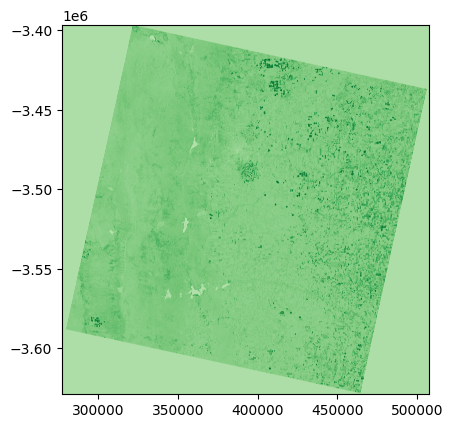

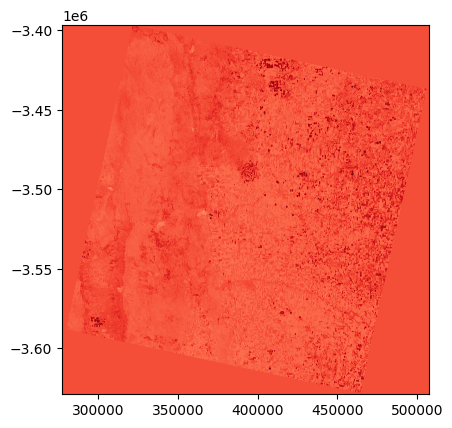

<Axes: >

In [9]:
#plot ndvi
ndvi = rasterio.open('./exports/ndviPreImage.tiff')
plot.show(ndvi, cmap="Greens")

#plot dnbr
dnbr = rasterio.open('./exports/dnbrPreImage.tiff')
plot.show(dnbr, cmap="Reds")

## Imagenes posteriores al incendio

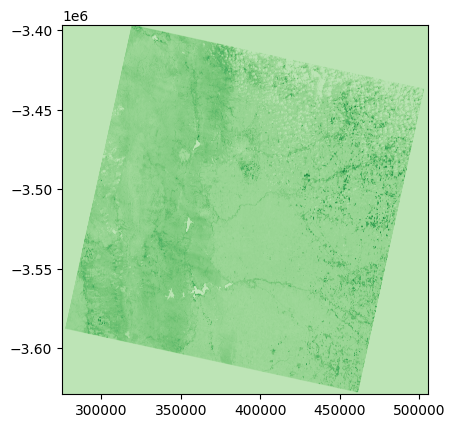

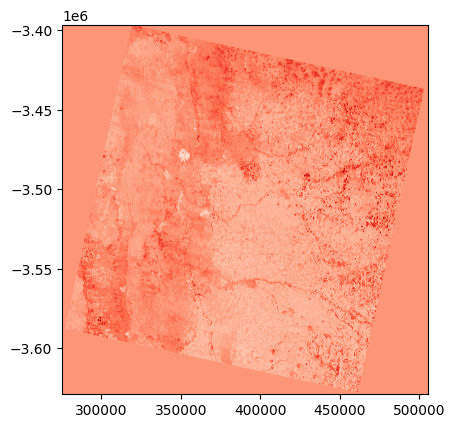

<Axes: >

In [10]:

#plot ndvi
ndvi = rasterio.open('./exports/ndviPostImage.tiff')
plot.show(ndvi, cmap="Greens")

#plot dnbr
dnbr = rasterio.open('./exports/dnbrPostImage.tiff')
plot.show(dnbr, cmap="Reds")

<br>

```
Nuestro siguiente objetivo es lograr utilizar las coordenadas de cada una de las parcelas.

Las mismas estan dentro del dataset de Santiago y San Roque.

Para ello nos conviene definir funciones que calculen el NDVI y DNBR, tanto previos como posteriores, para un poligono.

```

<br>


In [11]:
# Cargamos el NDVI previo y posterior antes de definir las funciones.
preNDVI = rasterio.open("./exports/ndviPreImage.tiff")
postNDVI = rasterio.open("./exports/ndviPostImage.tiff")

# Cargamos el DNBR previo y posterior antes de definir las funciones.
preDNBR = rasterio.open("./exports/dnbrPreImage.tiff")
postDNBR = rasterio.open("./exports/dnbrPostImage.tiff")

<br>

```
Nota: El sistema de coordenadas usado por el LANDSAT para las imagenes no son las mismas que usaron para este dataset de origen Argentino.
Por ello utilizaremos el transformador de coordenadas para poder tener a ambas en el mismo formato. (el del landsat)

```

<br>

In [12]:
# Creamos un trasnformador que nos cambia las coordenadas
transformer = Transformer.from_crs(crs_from="EPSG:22174",crs_to= "EPSG:32620", always_xy=True)

<br>

```
Definimos las funciones que toman el valor promedio en el poligono.

```

<br>

In [13]:
def previousNDVI( coords ): 
  # Transformo las coordenadas a la proyeccion correspondiente
    coords = [transformer.transform(x, y) for x, y in coords]
    poly = Polygon(coords)
    out_image, out_transform = rasterio.mask.mask(preNDVI, [poly], crop=True)
    return out_image.mean().item()

def posteriorNDVI( coords ): 
  # Transformo las coordenadas a la proyeccion correspondiente
    coords = [transformer.transform(x, y) for x, y in coords]
    poly = Polygon(coords)
    out_image, out_transform = rasterio.mask.mask(postNDVI, [poly], crop=True)
    return out_image.mean().item()

In [14]:
def previousDNBR( coords ): 
  # Transformo las coordenadas a la proyeccion correspondiente
    coords = [transformer.transform(x, y) for x, y in coords]
    poly = Polygon(coords)
    out_image, out_transform = rasterio.mask.mask(preDNBR, [poly], crop=True)
    return out_image.mean().item()

def posteriorDNBR( coords ): 
  # Transformo las coordenadas a la proyeccion correspondiente
    coords = [transformer.transform(x, y) for x, y in coords]
    poly = Polygon(coords)
    out_image, out_transform = rasterio.mask.mask(postDNBR, [poly], crop=True)
    return out_image.mean().item()

<br>

```
Por cada una de las parcelas en los datasets, corremos las funciones que declaramos!

```

<br>

In [15]:
Santiago["PreviousNDVI"]  = Santiago["geometry"].apply(lambda x: previousNDVI(x))
Santiago["PosteriorNDVI"] = Santiago["geometry"].apply(lambda x: posteriorNDVI(x))
Santiago["PreviousDNBR"]  = Santiago["geometry"].apply(lambda x: previousDNBR(x))
Santiago["PosteriorDNBR"] = Santiago["geometry"].apply(lambda x: posteriorDNBR(x))

SanRoque["PreviousNDVI"]  =  SanRoque["geometry"].apply(lambda x: previousNDVI(x))
SanRoque["PosteriorNDVI"] =  SanRoque["geometry"].apply(lambda x: posteriorNDVI(x))
SanRoque["PreviousDNBR"]  =  SanRoque["geometry"].apply(lambda x: previousDNBR(x))
SanRoque["PosteriorDNBR"] =  SanRoque["geometry"].apply(lambda x: posteriorDNBR(x))

<br>

```
Como son datasets un poco pesaditos, y con datos pendientes de refinar. Los exportamos, asi podemos usarlos luego.

```

<br>

In [16]:
path1= "./exports/SanRoque.csv"
path2= "./exports/Santiago.csv"

SanRoque.to_csv(path1, index=False)
Santiago.to_csv(path2, index=False)

### Los reclamos generados, tienen errores respecto a las pedanias. 


```

Es decir, la parcela que hizo reclamo en Santiago, no se encuentra en el dataset de informacion de las parcelas de Santiago!

```

## Solucion:
### Voy a proceder a separar los reclamos en Santiago o San Roque dependiendo donde esten.
### SPOILER: Hay 2 Datos que no pertenecen a ninguno, pero los trataremos al final.

In [17]:
# Empezamos cargando los datasets.
Santiago = pd.read_csv("./exports/Santiago.csv")
SanRoque = pd.read_csv("./exports/SanRoque.csv")
                                                                               

In [18]:
# Leemos los reclamos
data = pd.read_csv("Claims-WorkingFile_v2.csv")

# Extraemos la ID numerica
data["Id"] = data["idParcela"].apply(lambda x: int( x.split("-")[0] ))

data

,Propietario,direccion,TextoReclamo,ValorReclamo,idParcela,Valuacion_Danios,Validado,Id
0,Alma Gutierrez Cuesta,"Comuna de Tala Huasi, Pedanía San Roque, Depar...",A la atención de los señores de SierraVolt Ene...,1.656645e+07,2519551-SAN ROQUE,NaN,NaN,2519551
1,Rolando Iglesia Patiño,"Villa Carlos Paz, Municipio de Villa Carlos Pa...","Apreciados representantes de SierraV Segura,\r...",7.775383e+06,2449020-SANTIAGO,NaN,NaN,2449020
2,Ale Angelita Arias Blanco,"Villa Carlos Paz, Municipio de Villa Carlos Pa...",Para los distinguidos representantes de Sierra...,2.020116e+07,2448933-SAN ROQUE,NaN,NaN,2448933
3,Marco Barceló Luís,"Los Nogales, Comuna de Mayu Sumaj, Pedanía Sa...","Pa' Volterra Seguros,\r\n\r\nSoy Marco Barceló...",3.707236e+07,1205390-SANTIAGO,NaN,NaN,1205390
4,Pía Ligia Valdés Morán,"San Sebastián, Comuna de San Roque, Pedanía S...",A los representantes de SierraVolt Energética ...,1.311499e+05,1141971-SAN ROQUE,NaN,NaN,1141971
...,...,...,...,...,...,...,...,...
1042,Nerea Daza Andrade,"Comuna de Villa Río Icho Cruz, Pedanía Santiag...","A los representantes de SierraV Segura,\r\n\r\...",8.315284e+06,1204495-SAN ROQUE,NaN,NaN,1204495
1043,Osvaldo Cañas Cornejo,"Comuna de Tala Huasi, Pedanía San Roque, Depar...",A la atención de SierraVolt Energética Limitad...,5.547900e+07,1136506-SAN ROQUE,NaN,NaN,1136506
1044,Dominga Roig Diez,"Los Ceibos, La Quinta 4°, Villa Carlos Paz, M...",Para los distinguidos representantes de Sierra...,1.072323e+07,1173094-SAN ROQUE,NaN,NaN,1173094
1045,Adelia Montero Ribes,"78 Entre Ríos, Domingo Faustino Sarmiento, Vil...",A los Señores de SierraVolt Energética Limitad...,1.343024e+07,1181494-SAN ROQUE,NaN,NaN,1181494


<br>

```
Vemos que en el archivo de reclamos, hay 1047 generados. Y ahora si los filtramos, van a quedar 2 sin pertenecer a ninguna de las pedanias.

```

<br>

In [19]:
# Funcion que se fija en cual de los datasets esta un ID

def pedania( id ):
    SRQ = SanRoque["par_idparcela"].isin([id]).unique().size
    SNT = Santiago["par_idparcela"].isin([id]).unique().size

    if(SRQ == 2 and SNT == 1):
        return "San Roque"
    
    if(SRQ == 1 and SNT == 2):
        return "Santiago"

# Aplicamos la funcion para cada reclamo:
data["Pedania"] = data["Id"].apply( lambda x : pedania(x) )

# Soltamos los reclamos que no tengan Pedania definida
data = data.dropna(subset=["Pedania"]).reset_index(drop= True)

data

,Propietario,direccion,TextoReclamo,ValorReclamo,idParcela,Valuacion_Danios,Validado,Id,Pedania
0,Alma Gutierrez Cuesta,"Comuna de Tala Huasi, Pedanía San Roque, Depar...",A la atención de los señores de SierraVolt Ene...,1.656645e+07,2519551-SAN ROQUE,NaN,NaN,2519551,San Roque
1,Rolando Iglesia Patiño,"Villa Carlos Paz, Municipio de Villa Carlos Pa...","Apreciados representantes de SierraV Segura,\r...",7.775383e+06,2449020-SANTIAGO,NaN,NaN,2449020,San Roque
2,Ale Angelita Arias Blanco,"Villa Carlos Paz, Municipio de Villa Carlos Pa...",Para los distinguidos representantes de Sierra...,2.020116e+07,2448933-SAN ROQUE,NaN,NaN,2448933,San Roque
3,Marco Barceló Luís,"Los Nogales, Comuna de Mayu Sumaj, Pedanía Sa...","Pa' Volterra Seguros,\r\n\r\nSoy Marco Barceló...",3.707236e+07,1205390-SANTIAGO,NaN,NaN,1205390,Santiago
4,Pía Ligia Valdés Morán,"San Sebastián, Comuna de San Roque, Pedanía S...",A los representantes de SierraVolt Energética ...,1.311499e+05,1141971-SAN ROQUE,NaN,NaN,1141971,San Roque
...,...,...,...,...,...,...,...,...,...
1040,Nerea Daza Andrade,"Comuna de Villa Río Icho Cruz, Pedanía Santiag...","A los representantes de SierraV Segura,\r\n\r\...",8.315284e+06,1204495-SAN ROQUE,NaN,NaN,1204495,Santiago
1041,Osvaldo Cañas Cornejo,"Comuna de Tala Huasi, Pedanía San Roque, Depar...",A la atención de SierraVolt Energética Limitad...,5.547900e+07,1136506-SAN ROQUE,NaN,NaN,1136506,San Roque
1042,Dominga Roig Diez,"Los Ceibos, La Quinta 4°, Villa Carlos Paz, M...",Para los distinguidos representantes de Sierra...,1.072323e+07,1173094-SAN ROQUE,NaN,NaN,1173094,San Roque
1043,Adelia Montero Ribes,"78 Entre Ríos, Domingo Faustino Sarmiento, Vil...",A los Señores de SierraVolt Energética Limitad...,1.343024e+07,1181494-SAN ROQUE,NaN,NaN,1181494,San Roque


<br>

```
Ahora solo hay 1045 reclamos, nos sirve para empezar a entrenar, pero luego abordaremos que hicimos con los 2 reclamos sin informacion.

```

<br>

<br>

```
Dividimos los reclamos en reclamos de Santiago, y reclamos de San Roque.

De paso, nos quedamos solo con las parcelas que tengan un reclamo de los datasets importados anteriormente.

```

<br>

In [20]:
# Dividimos los reclamos por pedania.

claimsSantiago = data [ (data["Pedania"] == "Santiago") & (data["Id"].isin(Santiago["par_idparcela"])) ]
claimsSantiago = claimsSantiago.reset_index(drop=True)  #311

claimsSanRoque = data [ (data["Pedania"] == "San Roque") & (data["Id"].isin(SanRoque["par_idparcela"])) ]
claimsSanRoque = claimsSanRoque.reset_index(drop=True)  #734


# Luego filtramos las parcelas que solo tengan un reclamo y reseteamos el indice

claimedInfoSantiago = (Santiago[Santiago["par_idparcela"].isin(claimsSantiago["Id"])]).reset_index(drop=True)
claimedInfoSantiago = claimedInfoSantiago.reset_index(drop=True)  #311

claimedInfoSanRoque = (SanRoque[SanRoque["par_idparcela"].isin(claimsSanRoque["Id"])]).reset_index(drop=True)
claimedInfoSanRoque = claimedInfoSanRoque.reset_index(drop=True)  #734

# Sabemos que entonces todos los reclamos con pedania tienen informacion util.

<br>

```
Filtro las columnas de los reclamos sabiendo que son las que utilizaremos luego para predecir.

```

<br>

### Ahora el objetivo es hacer una red Neuronal que prediga la Valuacion de una pedania segun su NDVI, DNBR y otros datos. 
<br>

```
Si la red neuronal se encarga de predecir la valuacion, y estudia todo con los NDVI y DNBR previos.

Cuando haga predicciones con el NDVI y DNBR posteriores, van a haber cambios que simbolizen los daños.

```

<br>

Objetivo: Hacer un modelo que prediga la valuacion de un terreno en base datos preliminares del NDVI y DNBR (junto a otras cosas)

<br>

```
Comenzamos extrayendo las columnas que contienen informacion de:
 --> Valuacion total
 --> Valuaciones urbanas, Rurales y de Mejoras
 --> DNBR y NDVI previos y posteriores

```

<br>

In [21]:
# Columnas de interes
reqCols = [
    "Valuacion",                                 
    "Superficie_Tierra_Urbana",        
    "Valuacion_Tierra_Urbana",         
    "base_imponible_tierra_urbana",    
    "Superficie_Tierra_Rural",         
    "Valuacion_Tierra_Rural",          
    "base_imponible_tierra_rural",     
    "Superficie_Mejoras",              
    "Valuacion_Mejoras",               
    "base_imponible_mejoras",                                                                                                          
    "PreviousNDVI",                    
    "PosteriorNDVI",                   
    "PreviousDNBR",                    
    "PosteriorDNBR",
]

# Datos de los datasets filtrados
SantiagoRefinado = Santiago.select_dtypes(include="number").reindex(columns=reqCols)
SanRoqueRefinado = SanRoque.select_dtypes(include="number").reindex(columns=reqCols)

# Concatenacion de los datos
data = pd.concat([SanRoqueRefinado, SantiagoRefinado])

# Y Ahora del dataset separamos las columnas que tenga los datos previos al incendio
# Tambien cambio el nombre a DNBR y NDVI, para hacerlo evidente
dataPreIncendio = data.drop(columns=["PosteriorNDVI", "PosteriorDNBR"]).rename(columns={"PreviousDNBR" : "DNBR", "PreviousNDVI" : "NDVI"})


# Con la data PRE INCENCIO hacemos una red neuronal que aprenda a calcular las valuaciones...

dataPreIncendio

,Valuacion,Superficie_Tierra_Urbana,Valuacion_Tierra_Urbana,base_imponible_tierra_urbana,Superficie_Tierra_Rural,Valuacion_Tierra_Rural,base_imponible_tierra_rural,Superficie_Mejoras,Valuacion_Mejoras,base_imponible_mejoras,NDVI,DNBR
0,229600.000,656.00,229600.0,0,0,0.0,0,0.0,0.00,0,0.000000,0.000000
1,9971826.400,1368.41,1231569.0,0,0,0.0,0,343.0,8740257.40,0,0.039547,-0.009117
2,2911239.000,780.00,518700.0,0,0,0.0,0,110.0,2392539.00,0,0.031888,-0.008190
3,2748300.480,714.00,539784.0,0,0,0.0,0,150.0,2208516.48,0,0.034409,0.003829
4,5791000.990,560.00,823200.0,0,0,0.0,0,276.0,4967800.99,0,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
5578,2507722.520,327.00,721035.0,0,0,0.0,0,230.0,1786687.52,0,0.000000,0.000000
5579,385560.000,720.00,385560.0,0,0,0.0,0,0.0,0.00,0,0.031041,0.006266
5580,539784.000,1224.00,539784.0,0,0,0.0,0,0.0,0.00,0,0.013173,-0.005579
5581,971586.000,701.00,971586.0,0,0,0.0,0,0.0,0.00,0,0.035400,-0.004924


<br>

```
Para una mejor performance de la red, escalamos los datos previos al incendio

```

<br>

In [22]:
scaler = MinMaxScaler()

scaledDataPreIncendio = pd.DataFrame( scaler.fit_transform(dataPreIncendio) )

scaledDataPreIncendio.columns = dataPreIncendio.columns

scaledDataPreIncendio


,Valuacion,Superficie_Tierra_Urbana,Valuacion_Tierra_Urbana,base_imponible_tierra_urbana,Superficie_Tierra_Rural,Valuacion_Tierra_Rural,base_imponible_tierra_rural,Superficie_Mejoras,Valuacion_Mejoras,base_imponible_mejoras,NDVI,DNBR
0,0.000309,0.001029,0.000382,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.011448,0.355349
1,0.013426,0.002146,0.002049,0.0,0.0,0.0,0.0,0.006556,0.006550,0.0,0.133051,0.325426
2,0.003920,0.001223,0.000863,0.0,0.0,0.0,0.0,0.002102,0.001793,0.0,0.109501,0.328468
3,0.003700,0.001120,0.000898,0.0,0.0,0.0,0.0,0.002867,0.001655,0.0,0.117254,0.367916
4,0.007797,0.000878,0.001370,0.0,0.0,0.0,0.0,0.005275,0.003723,0.0,0.011448,0.355349
...,...,...,...,...,...,...,...,...,...,...,...,...
65092,0.003376,0.000513,0.001200,0.0,0.0,0.0,0.0,0.004396,0.001339,0.0,0.011448,0.355349
65093,0.000519,0.001129,0.000642,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.106898,0.375918
65094,0.000727,0.001920,0.000898,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.051954,0.337037
65095,0.001308,0.001099,0.001617,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.120301,0.339186


<br>

```
Definimos una funcion que grafique el error de la funcion perdida de la red.

Y entrenamos una red neuronal para que aprenda el patron en estos datos y prediga la valuacion.

```

<br>

In [23]:
# Armamos una funcion para graficar el error a través de las épocas
def graficar_error(history, error_name):
    x_arr = np.array(history.epoch)
    plot = (
        so.Plot()
        .add(so.Line(color='blue'), x=x_arr, y=history.history[error_name], label='Entrenamiento')
        .add(so.Line(color='orange'), x=x_arr, y=history.history[f'val_{error_name}'], label='Validacion')
        .label(title=error_name)
    )
    plot.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 3.2993e-05


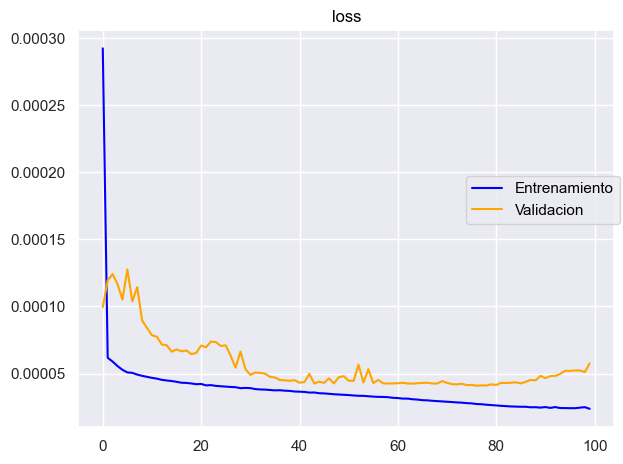

In [24]:
dTrain, dTest = train_test_split(scaledDataPreIncendio, test_size=0.2, random_state=13)

X_train = dTrain.drop(columns= "Valuacion")
y_train = dTrain["Valuacion"]

X_test = dTest.drop(columns= "Valuacion")
y_test = dTest["Valuacion"]

keras.utils.set_random_seed(13)

# Paso 1: iniciamos el modelo indicando la arquitectura de la red
model = keras.Sequential([
    keras.layers.Input(shape=(X_train.shape[1],)),

    keras.layers.Dense(20,
                       activation='elu'),
                       
    keras.layers.Dense(20,
                       activation='elu'),
                       
    keras.layers.Dense(20,
                       activation='elu'),
                       
    keras.layers.Dense(20,
                       activation='elu'),

    keras.layers.Dense(1)
])

# Paso 2: configuramos el optimizador
optimizer = keras.optimizers.Adam()

# Paso 3: construimos el modelo
model.compile(
    optimizer=optimizer,
    loss='mean_squared_error',
)

# Paso 4: entrenamiento del modelo.
hist = model.fit(X_train.to_numpy(), y_train.to_numpy(),
                 epochs=100,
                 batch_size=20,
                 validation_split=0.2,
                 verbose=0
                 )

# Paso 5: calculamos el error en el conjunto de testeo
model.evaluate(X_test.to_numpy(), y_test.to_numpy(),
               batch_size=len(y_test),
               return_dict=True
               )

# Paso 6: graficamos la funcion de perdida
graficar_error(hist, 'loss')

<br>

```
La grafica de la funcion perdida de la red, parece bastante decente.

Defino una funcion que genere predicciones desde un elemento del dataframe. 

Y procedemos a usarla dentro de la informacion de los reclamos

```

<br>

In [25]:

def predict(entry):
    # Suponemos que la entrada tiene la misma forma que deberia tener del entrenamiento
    
    scaledEntry = pd.DataFrame(scaler.transform(entry))
    scaledEntry.columns = entry.columns

    val = model.predict(scaledEntry.drop(columns="Valuacion"), verbose=0)
    
    scaledEntry["Valuacion"] = val
    

    inverseScaled = pd.DataFrame( scaler.inverse_transform(scaledEntry) )
    inverseScaled.columns = entry.columns

    return (inverseScaled["Valuacion"].item())

In [26]:
reqCols = [
"par_idparcela",
 'Valuacion',
 'Superficie_Tierra_Urbana',
 'Valuacion_Tierra_Urbana',
 'base_imponible_tierra_urbana',
 'Superficie_Tierra_Rural',
 'Valuacion_Tierra_Rural',
 'base_imponible_tierra_rural',
 'Superficie_Mejoras',
 'Valuacion_Mejoras',
 'base_imponible_mejoras',
 'NDVI',
 'DNBR']

# Filtramos los reclamos y generamos las predicciones

SetPostSantiago = claimedInfoSantiago.rename(columns={"PosteriorNDVI" : "NDVI", "PosteriorDNBR": "DNBR"}).reindex(columns=reqCols)
SetPostSanRoque = claimedInfoSanRoque.rename(columns={"PosteriorNDVI" : "NDVI", "PosteriorDNBR": "DNBR"}).reindex(columns=reqCols)

In [27]:
# Post santiago
aux = []

for index in range(0, SetPostSantiago.shape[0]):
    elem = SetPostSantiago.iloc[[index]].drop(columns=["par_idparcela"])
    pred = predict(elem)
    aux.append(pred)

claimedInfoSantiago["ValuacionPost"] = pd.Series(aux)

In [28]:
# Post SanRoque
aux = []

for index in range(0, SetPostSanRoque.shape[0]):
    elem = SetPostSanRoque.iloc[[index]].drop(columns=["par_idparcela"])
    pred = predict(elem)
    aux.append(pred)

claimedInfoSanRoque["ValuacionPost"] = pd.Series(aux)

<br>

```
Tomamos como Valucion Diferencial, a la diferencia entre la valuacion real y la valuacion predecida por el Modelo.
con los datos POSTERIORES al incendio.

```

<br>

In [29]:
claimedInfoSanRoque["ValuacionDiferencial"] = (claimedInfoSanRoque["Valuacion"] - claimedInfoSanRoque["ValuacionPost"])
claimedInfoSantiago["ValuacionDiferencial"] = (claimedInfoSantiago["Valuacion"] - claimedInfoSantiago["ValuacionPost"])

<br>

```
Sabemos que el modelo raramente es perfecto, entonces queremos saber.

Cuantas diferencias son negativas?? (Es decir, el modelo dice que valen mas que antes del incendio)
```

<br>

In [30]:
print( f"San Roque: {claimedInfoSanRoque[(claimedInfoSanRoque["ValuacionDiferencial"]<0)].shape[0]}, Santiago {claimedInfoSantiago[(claimedInfoSantiago["ValuacionDiferencial"]<0)].shape[0]} " )

San Roque: 66, Santiago 23 


<br>

```
Considerando que son 734 de San Roque y 311 de Santiago, no son tantas. Es una buena señal.

Vamos a tomar el quantil 0.20 de cada una de las valuaciones de los daños. (es decir casi la minima)

Y asignar ese daño a las parcelas que tengan diferencias negativas.
```

<br>

In [31]:


# Santiago
ResSantiago = claimedInfoSantiago
ResSantiago = ResSantiago.rename(columns={"par_idparcela":"idParcela", "ValuacionDiferencial":"Valuación Daño"})

ResQuantileSantiago = ResSantiago[ResSantiago["Valuación Daño"]>0]["Valuación Daño"].quantile(0.20)


# SanRoque
ResSanRoque = claimedInfoSanRoque
ResSanRoque = ResSanRoque.rename(columns={"par_idparcela":"idParcela", "ValuacionDiferencial":"Valuación Daño"})

ResQuantileSanRoque = ResSanRoque[ResSanRoque["Valuación Daño"]>0]["Valuación Daño"].quantile(0.20)


# Prom total
TotalQuantileMean = pd.Series([ResQuantileSanRoque, ResQuantileSantiago]).mean()

TotalQuantileMean

524486.1515114147

In [32]:
# Les asignamos a los valores de daños negativos una compensacion minima
ResSantiago["Valuación Daño"] = ResSantiago["Valuación Daño"].apply( lambda x: x if (x>0) else ResQuantileSantiago )
ResSanRoque["Valuación Daño"] = ResSanRoque["Valuación Daño"].apply( lambda x: x if (x>0) else ResQuantileSanRoque )

<br>

```
Y listo, ahora tenemos nuestros resultados de SanRoque y de Santiago preparados para exportarse

```

<br>

## Retiramos los resultados y los exportamos como csv


<br>

```
Leemos los datos del test de Kaggle
```

<br>

In [33]:
# Importo los datos
data = pd.read_csv("test.csv")

# Extraigo el ID numerico
data["idParcela"] = data["idParcela"].apply(lambda x: int( x.split("-")[0] ))

data.iloc[0:2]

,idParcela
0,2519551
1,2449020


<br>

```
Ahora concateno los resultados de San Roque y Santiago
```

<br>

In [34]:
total = pd.concat([ResSanRoque, ResSantiago]).reindex(columns=["idParcela", "Valuación Daño"])
total.iloc[0:2]

,idParcela,Valuación Daño
0,2519552,585284.234318
1,1136508,713543.317033


<br>

```
Con los 2 datos que no figuraban en ninguna pedania, decidi darles la minima de las valuaciones.
```

<br>

In [35]:
# Los 2 datos fuera de las pedanias...
unknown = pd.DataFrame()
unknown["idParcela"] = data["idParcela"][~(data["idParcela"].isin(total["idParcela"]))]
unknown["Valuación Daño"] = [TotalQuantileMean, TotalQuantileMean]

unknown

,idParcela,Valuación Daño
563,1134775,524486.151511
942,1134779,524486.151511


<br>

```
Unimos los datos desconocidos con los totales!
```

<br>

In [36]:
total = pd.concat([unknown, total])


<br>

```
Mergeo los datos totales segun la ID con los del TEST
```

<br>

In [37]:
# Merge
data = data.merge(total, on="idParcela")
data["Valuación Daño"] = data["Valuación Daño"].astype(int) # Redondeo las valuaciones.

data.iloc[0:2]

,idParcela,Valuación Daño
0,2519551,550189
1,2449020,669814



<br>

```
Y por ultimo volvemos a los IDs originales
```

<br>

In [38]:
# Arreglamos los ID
aux = pd.read_csv("test.csv")

data["idParcela"] = aux["idParcela"]

data.iloc[0:2]

,idParcela,Valuación Daño
0,2519551-SAN ROQUE,550189
1,2449020-SAN ROQUE,669814


In [39]:
# Exportamos las predicciones.
data.to_csv("Valuaciones finales del kaggle.csv", index=False)